# Mini-projet XAI — Explication pour la Détection d'Objets
## Adaptation de Grad-CAM pour expliquer les boîtes de détection (YOLO / Faster R-CNN)

---

**Étudiants :**
- Nom Prénom 1 : Zouga Mouhcine
- Nom Prénom 2 : Amllal Amine 


**Date :** 11 décembre 2024

---

**Résumé :** Ce notebook illustre comment adapter les techniques d'explicabilité (XAI), notamment Grad-CAM, pour expliquer les prédictions de modèles de détection d'objets. Contrairement à la classification simple où l'on explique une classe, nous expliquons ici *pourquoi une boîte englobante a été prédite à cet endroit*.

##  Contexte & Motivation

### Le problème

Les modèles de **détection d'objets** (YOLO, Faster R-CNN, SSD, etc.) sont aujourd'hui omniprésents dans les applications de vision par ordinateur : véhicules autonomes, surveillance vidéo, imagerie médicale, contrôle qualité industriel, etc. Ces modèles prédisent simultanément :
- **Où** se trouvent les objets (boîtes englobantes / *bounding boxes*)
- **Quoi** sont ces objets (classe : chien, voiture, personne...)
- **À quel point** le modèle est confiant (score de confiance)

Cependant, ces réseaux de neurones profonds sont des **boîtes noires** : ils fournissent des prédictions sans expliquer *pourquoi* une boîte a été placée à un endroit précis.

### Pourquoi l'explicabilité ?

Dans des contextes critiques (médecine, sécurité, justice), il est essentiel de pouvoir :
- **Comprendre** les décisions du modèle
- **Vérifier** qu'il se base sur les bonnes caractéristiques visuelles
- **Détecter** les biais ou les raccourcis appris (ex: détecter un chien grâce à la laisse plutôt qu'au chien lui-même)

### Type d'explication

La méthode que nous utilisons (Grad-CAM adapté) fournit une **explication locale** : elle explique *une prédiction spécifique* (une boîte précise) plutôt que le comportement global du modèle.

##  Intuition de la méthode (sans formule)

### L'idée principale de Grad-CAM

Imaginons que vous demandez à un ami de vous montrer *où il regarde* quand il reconnaît un chien sur une photo. Grad-CAM fait exactement cela avec un réseau de neurones !

**Grad-CAM (Gradient-weighted Class Activation Mapping)** est une technique qui :

1. **Regarde "en arrière"** dans le réseau : elle utilise les gradients (la rétropropagation) pour comprendre quelles parties de l'image ont le plus influencé la décision.

2. **Se concentre sur les feature maps** : au lieu de regarder tous les pixels, elle analyse les cartes de caractéristiques de la dernière couche convolutive, qui contiennent des informations sémantiques de haut niveau.

3. **Pondère ces cartes** : chaque carte de caractéristiques est pondérée par son importance pour la prédiction ciblée.

### Adaptation pour la détection d'objets

Pour la **classification simple**, on cible le score d'une classe (ex: "chien").

Pour la **détection d'objets**, on adapte en ciblant :
- Le **score de confiance d'une boîte spécifique**
- Ou le **score de classe associé à cette boîte**

Ainsi, on peut répondre à : *"Pourquoi le modèle pense qu'il y a un chien ICI ?"*

### Sortie de la méthode

La sortie est une **heatmap** (carte de chaleur) :
- **Couleurs chaudes (rouge/jaune)** → zones très importantes pour la prédiction
- **Couleurs froides (bleu)** → zones peu importantes
- Superposée sur l'image originale pour visualisation

### Famille XAI

Grad-CAM appartient à la famille des méthodes **basées sur les gradients** :
- ✅ **Gradient-based** : utilise la rétropropagation
- ❌ Pas de perturbation (contrairement à LIME/SHAP)
- ❌ Pas de modèle proxy/surrogate
- ❌ Pas de contrefactuels

C'est une méthode **rapide** (un seul passage forward + backward) et **model-agnostic** pour les CNN.

##  Formalisation mathématique

### Équation 1 : Calcul des poids d'importance

Pour une classe cible $c$ (ou un score de boîte), on calcule l'importance de chaque feature map $k$ :

$$\alpha_k^c = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A_{ij}^k}$$

**Explication des symboles :**
- $\alpha_k^c$ : poids d'importance de la feature map $k$ pour la classe/boîte $c$
- $y^c$ : score de sortie pour la classe $c$ (ou confiance de la boîte)
- $A_{ij}^k$ : activation à la position $(i,j)$ de la $k$-ième feature map
- $Z$ : facteur de normalisation (nombre de pixels dans la feature map)
- $\frac{\partial y^c}{\partial A_{ij}^k}$ : **gradient** — mesure combien $y^c$ change quand $A_{ij}^k$ change

> 💡 **Lien avec vos connaissances** : Ce gradient est exactement ce que calcule la **rétropropagation** ! On fait un backward pass pour obtenir ces dérivées partielles.

---

### Équation 2 : Construction de la heatmap

On combine toutes les feature maps pondérées :

$$L_{Grad-CAM}^c = ReLU\left(\sum_{k} \alpha_k^c \cdot A^k\right)$$

**Explication des symboles :**
- $L_{Grad-CAM}^c$ : heatmap finale pour la classe/boîte $c$
- $\sum_{k} \alpha_k^c \cdot A^k$ : somme pondérée de toutes les feature maps
- $ReLU$ : fonction qui garde uniquement les valeurs positives

> 💡 **Pourquoi ReLU ?** On ne s'intéresse qu'aux caractéristiques qui ont une influence **positive** sur la prédiction. Les influences négatives correspondraient à d'autres classes.

---

### Adaptation pour la détection

Pour une boîte de détection $b$ avec classe $c$ et confiance $p$, on peut définir :

$$y^{(b,c)} = p_b \cdot \mathbb{1}_{classe=c}$$

Ou simplement utiliser le score de confiance $p_b$ de la boîte comme cible pour les gradients.

---

### Schéma récapitulatif

```
Image → CNN Backbone → Feature Maps (A^k) → Détection Head → Boîtes + Scores
                              ↓                                    ↓
                        Gradients (∂y/∂A) ←←←←←←←←←←←←←← Score cible (y^c)
                              ↓
                    Poids α = moyenne(gradients)
                              ↓
                    Heatmap = ReLU(Σ α_k · A^k)
```

##  Implémentation / Démonstration

### a) Installation des dépendances

Nous utilisons :
- **PyTorch** & **torchvision** : pour le modèle Faster R-CNN pré-entraîné
- **pytorch-grad-cam** : librairie facilitant l'application de Grad-CAM
- **OpenCV** & **Matplotlib** : pour le traitement et la visualisation d'images

In [1]:
# Installation des dépendances (décommenter si nécessaire)
# !pip install torch torchvision
# !pip install grad-cam
# !pip install opencv-python
# !pip install requests pillow matplotlib numpy

In [2]:
# Imports
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
from io import BytesIO
import cv2
import warnings
warnings.filterwarnings('ignore')

# Vérification GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")
print(f"PyTorch version : {torch.__version__}")
print(f"Torchvision version : {torchvision.__version__}")

Device utilisé : cuda
PyTorch version : 2.7.1+cu118
Torchvision version : 0.22.1+cu118


### b) Chargement du modèle de détection pré-entraîné

Nous utilisons **Faster R-CNN** avec un backbone **ResNet-50 + FPN** (Feature Pyramid Network), pré-entraîné sur **COCO** (80 classes d'objets).

**Architecture du modèle :**
- **Backbone (ResNet-50)** : extrait les caractéristiques visuelles (feature maps)
- **FPN** : combine features à différentes résolutions pour détecter objets de toutes tailles
- **RPN (Region Proposal Network)** : propose des régions candidates
- **ROI Head** : classifie et affine les boîtes

In [3]:
# Chargement du modèle Faster R-CNN pré-entraîné sur COCO
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
model = model.to(device)
model.eval()

# Labels COCO (91 classes, mais seulement 80 utilisées + background)
COCO_CLASSES = weights.meta["categories"]
print(f"Nombre de classes : {len(COCO_CLASSES)}")
print(f"Exemples de classes : {COCO_CLASSES[:15]}...")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Mouhcine/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:07<00:00, 23.9MB/s] 



Nombre de classes : 91
Exemples de classes : ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter']...


### c) Chargement des images de test

Nous utilisons quelques images contenant des objets variés pour illustrer nos explications.

✓ Image 'chien' chargée : (640, 427)
✓ Image 'chat' chargée : (640, 440)
✓ Image 'rue' chargée : (640, 427)
✓ Image 'rue' chargée : (640, 427)


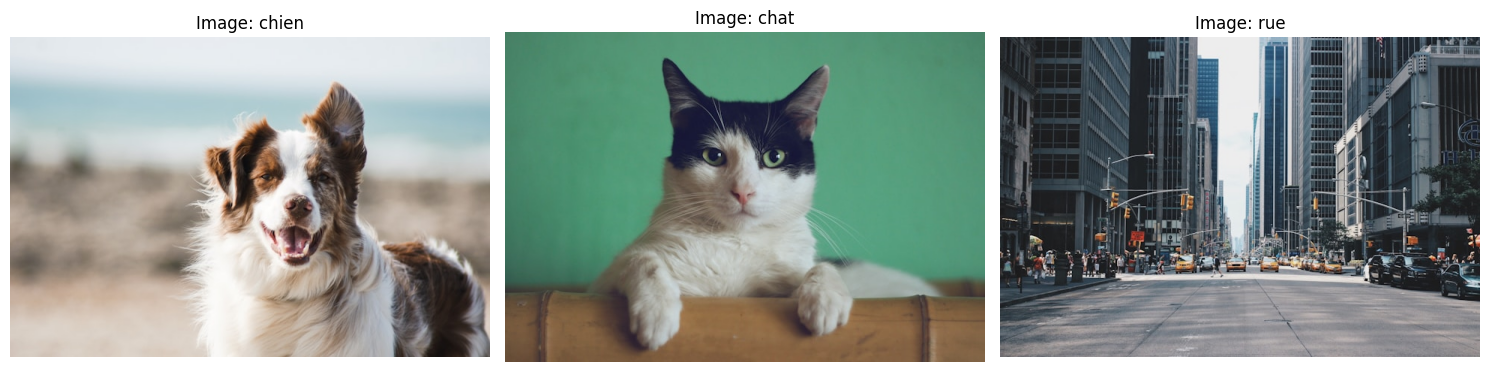

In [6]:
def load_image_from_url(url):
    """Charge une image depuis une URL"""
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def preprocess_image(img):
    """Prétraitement pour le modèle"""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(img)

# URLs d'images de test fiables (images de Unsplash - libres de droits)
image_urls = {
    "chien": "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=640",
    "chat": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=640",
    "rue": "https://images.unsplash.com/photo-1449824913935-59a10b8d2000?w=640"
}

# Charger les images
images = {}
for name, url in image_urls.items():
    try:
        images[name] = load_image_from_url(url)
        print(f"✓ Image '{name}' chargée : {images[name].size}")
    except Exception as e:
        print(f"✗ Erreur pour '{name}': {e}")

# Vérifier qu'on a au moins une image
if len(images) == 0:
    print("\n⚠️ Aucune image chargée depuis les URLs. Création d'une image de test...")
    # Créer une image de test simple avec des formes
    test_img = Image.new('RGB', (640, 480), color=(100, 150, 200))
    images["test"] = test_img
    print("✓ Image de test créée")

# Afficher les images
n_images = len(images)
fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
if n_images == 1:
    axes = [axes]
for ax, (name, img) in zip(axes, images.items()):
    ax.imshow(img)
    ax.set_title(f"Image: {name}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### d) Exécution de la détection d'objets

Appliquons le modèle Faster R-CNN sur nos images pour obtenir les boîtes de détection.

In [7]:
def detect_objects(model, img, threshold=0.5):
    """
    Effectue la détection d'objets sur une image.
    
    Args:
        model: Modèle de détection
        img: Image PIL
        threshold: Seuil de confiance minimum
    
    Returns:
        boxes, labels, scores: Détections filtrées
    """
    # Prétraitement
    img_tensor = preprocess_image(img).to(device)
    
    # Inférence
    with torch.no_grad():
        predictions = model([img_tensor])[0]
    
    # Filtrage par seuil de confiance
    mask = predictions['scores'] > threshold
    boxes = predictions['boxes'][mask].cpu().numpy()
    labels = predictions['labels'][mask].cpu().numpy()
    scores = predictions['scores'][mask].cpu().numpy()
    
    return boxes, labels, scores

def visualize_detections(img, boxes, labels, scores, class_names, ax=None):
    """Visualise les détections sur l'image"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    ax.imshow(img)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        x1, y1, x2, y2 = box
        color = colors[label % 10]
        
        # Rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Label
        class_name = class_names[label] if label < len(class_names) else f"class_{label}"
        ax.text(
            x1, y1 - 5,
            f"{class_name}: {score:.2f}",
            color='white', fontsize=10,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8)
        )
    
    ax.axis('off')
    return ax

# Effectuer les détections sur chaque image
all_detections = {}

for name, img in images.items():
    boxes, labels, scores = detect_objects(model, img, threshold=0.5)
    all_detections[name] = {
        'image': img,
        'boxes': boxes,
        'labels': labels,
        'scores': scores
    }
    print(f"\n📦 Détections pour '{name}':")
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        class_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f"class_{label}"
        print(f"   {i+1}. {class_name} (confiance: {score:.2%})")


📦 Détections pour 'chien':
   1. dog (confiance: 99.50%)

📦 Détections pour 'chat':
   1. cat (confiance: 99.69%)

📦 Détections pour 'chat':
   1. cat (confiance: 99.69%)

📦 Détections pour 'rue':
   1. car (confiance: 99.73%)
   2. person (confiance: 99.05%)
   3. car (confiance: 98.85%)
   4. traffic light (confiance: 98.56%)
   5. person (confiance: 98.12%)
   6. car (confiance: 97.87%)
   7. car (confiance: 97.80%)
   8. car (confiance: 97.78%)
   9. car (confiance: 97.78%)
   10. car (confiance: 97.46%)
   11. person (confiance: 97.09%)
   12. person (confiance: 97.08%)
   13. car (confiance: 96.36%)
   14. person (confiance: 96.33%)
   15. person (confiance: 95.83%)
   16. traffic light (confiance: 95.34%)
   17. car (confiance: 95.32%)
   18. car (confiance: 95.19%)
   19. traffic light (confiance: 94.77%)
   20. car (confiance: 94.72%)
   21. car (confiance: 92.81%)
   22. person (confiance: 91.69%)
   23. traffic light (confiance: 91.36%)
   24. car (confiance: 86.74%)
   25.

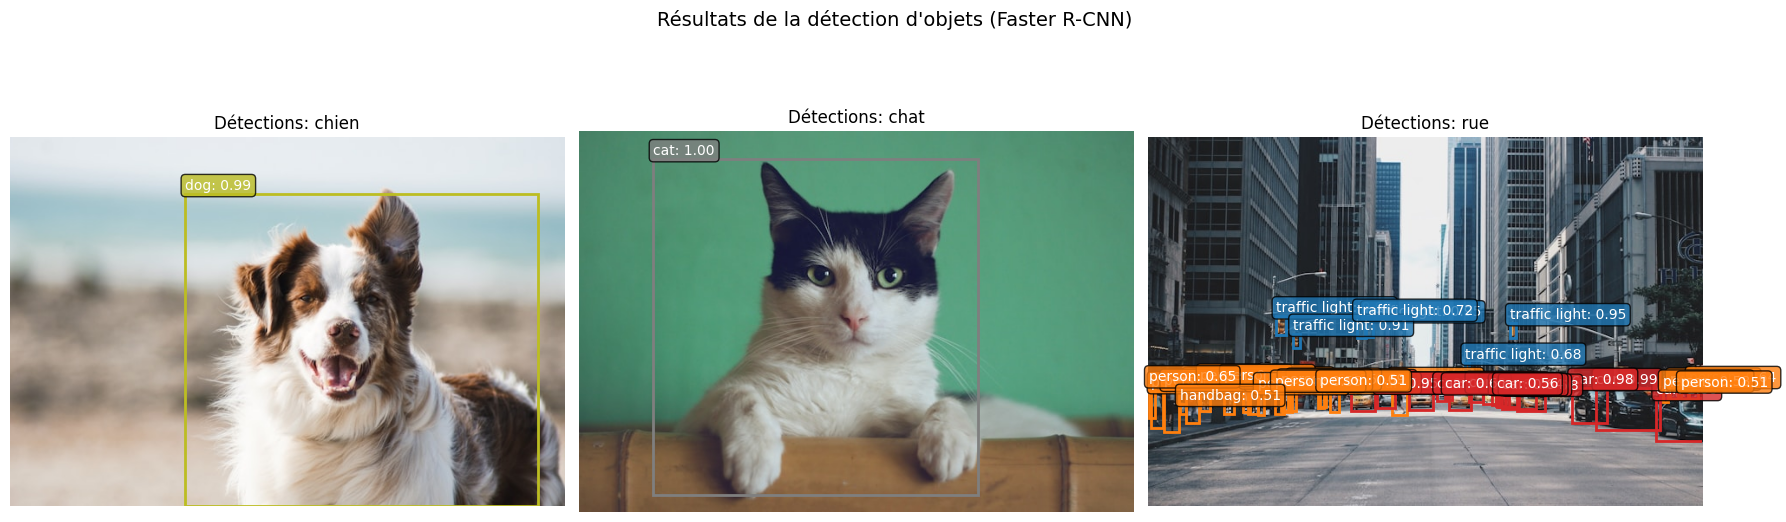

In [8]:
# Visualiser toutes les détections
fig, axes = plt.subplots(1, len(all_detections), figsize=(18, 6))
if len(all_detections) == 1:
    axes = [axes]

for ax, (name, det) in zip(axes, all_detections.items()):
    visualize_detections(
        det['image'], det['boxes'], det['labels'], 
        det['scores'], COCO_CLASSES, ax=ax
    )
    ax.set_title(f"Détections: {name}", fontsize=12)

plt.tight_layout()
plt.suptitle("Résultats de la détection d'objets (Faster R-CNN)", y=1.02, fontsize=14)
plt.show()

### e) Implémentation de Grad-CAM pour la Détection

Nous allons maintenant implémenter Grad-CAM adapté pour expliquer les boîtes de détection. L'idée est de cibler le score d'une boîte spécifique et de calculer les gradients par rapport aux feature maps du backbone.

In [11]:
class GradCAMForDetection:
    """
    Implémentation de Grad-CAM adaptée pour la détection d'objets.
    
    Cette classe permet de générer des heatmaps expliquant pourquoi
    une boîte de détection spécifique a été prédite.
    
    Note: Pour Faster R-CNN, on utilise une approche en deux passes:
    1. Forward en mode eval pour obtenir les détections
    2. Calcul des gradients via les feature maps du backbone
    """
    
    def __init__(self, model, target_layer):
        """
        Args:
            model: Modèle de détection (ex: Faster R-CNN)
            target_layer: Couche cible pour extraire les feature maps
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        # Enregistrer les hooks pour capturer gradients et activations
        self._register_hooks()
    
    def _register_hooks(self):
        """Enregistre les hooks sur la couche cible"""
        
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
            # Activer requires_grad pour permettre le backward
            self.activations.requires_grad_(True)
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        h1 = self.target_layer.register_forward_hook(forward_hook)
        h2 = self.target_layer.register_full_backward_hook(backward_hook)
        self.handles = [h1, h2]
    
    def generate_cam(self, img_tensor, box_index=0):
        """
        Génère la heatmap Grad-CAM pour une boîte spécifique.
        
        Approche: On utilise le backbone directement pour calculer les gradients
        par rapport aux feature maps, en ciblant la région de la boîte détectée.
        """
        self.model.eval()
        self.gradients = None
        self.activations = None
        
        # Étape 1: Obtenir les détections en mode eval
        with torch.no_grad():
            predictions = self.model([img_tensor.clone()])[0]
        
        if len(predictions['scores']) == 0:
            return None, predictions
        
        if box_index >= len(predictions['scores']):
            box_index = 0
        
        target_box = predictions['boxes'][box_index]
        target_score = predictions['scores'][box_index].item()
        target_label = predictions['labels'][box_index].item()
        
        # Étape 2: Forward pass avec gradients activés sur le backbone seulement
        img_input = img_tensor.clone().requires_grad_(True)
        
        # Passer par le backbone pour obtenir les features
        features = self.model.backbone(img_input.unsqueeze(0) if img_input.dim() == 3 else img_input)
        
        # Les activations ont été capturées par le hook
        if self.activations is None:
            print("Warning: Activations non capturées, utilisation d'une approche alternative")
            # Approche alternative: utiliser directement les features du FPN
            if isinstance(features, dict):
                # FPN retourne un dict, prendre le niveau le plus profond
                feat_key = list(features.keys())[-1]
                activation = features[feat_key]
            else:
                activation = features
            self.activations = activation
        
        # Étape 3: Créer un score cible basé sur la région de la boîte
        # On utilise les activations dans la région de la boîte comme proxy
        h, w = self.activations.shape[-2:]
        img_h, img_w = img_tensor.shape[-2:]
        
        # Convertir les coordonnées de la boîte vers l'espace des features
        x1, y1, x2, y2 = target_box.cpu().numpy()
        fx1 = int(x1 * w / img_w)
        fy1 = int(y1 * h / img_h)
        fx2 = max(fx1 + 1, int(x2 * w / img_w))
        fy2 = max(fy1 + 1, int(y2 * h / img_h))
        
        # Créer le score cible: moyenne des activations dans la région
        activation_tensor = self.activations.clone().requires_grad_(True)
        target = activation_tensor[:, :, fy1:fy2, fx1:fx2].mean()
        
        # Backward pass
        self.model.zero_grad()
        if img_input.grad is not None:
            img_input.grad.zero_()
        
        target.backward(retain_graph=True)
        
        # Calculer les gradients par rapport aux activations
        if self.gradients is not None:
            gradients = self.gradients
        else:
            # Si les gradients du hook ne sont pas disponibles, calculer manuellement
            gradients = torch.autograd.grad(target, activation_tensor, retain_graph=True)[0]
        
        # Calculer les poids (Global Average Pooling des gradients)
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        
        # Combiner les feature maps pondérées
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        
        # Appliquer ReLU
        cam = torch.relu(cam)
        
        # Normaliser
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy(), {
            'boxes': predictions['boxes'].cpu(),
            'scores': predictions['scores'].cpu(),
            'labels': predictions['labels'].cpu()
        }
    
    def cleanup(self):
        """Supprime les hooks"""
        for h in self.handles:
            h.remove()


# Identifier la couche cible dans le backbone ResNet
# On cible la dernière couche du layer4 (avant le pooling global)
target_layer = model.backbone.body.layer4[-1]
print(f"Couche cible : {target_layer.__class__.__name__}")

# Créer l'objet Grad-CAM
gradcam = GradCAMForDetection(model, target_layer)
print("✓ Grad-CAM initialisé avec succès")

Couche cible : Bottleneck
✓ Grad-CAM initialisé avec succès


### f) Génération des explications Grad-CAM

Appliquons maintenant Grad-CAM sur plusieurs boîtes de détection pour comprendre quelles régions de l'image justifient chaque détection.

In [12]:
def generate_gradcam_for_detections(gradcam, img, detections, num_boxes=3):
    """
    Génère les heatmaps Grad-CAM pour plusieurs boîtes.
    
    Args:
        gradcam: Instance de GradCAMForDetection
        img: Image PIL
        detections: Dictionnaire avec boxes, labels, scores
        num_boxes: Nombre de boîtes à expliquer
        
    Returns:
        results: Liste de tuples (cam, box, label, score)
    """
    img_tensor = preprocess_image(img).to(device)
    results = []
    
    num_boxes = min(num_boxes, len(detections['boxes']))
    
    for i in range(num_boxes):
        # Réinitialiser le modèle pour chaque boîte
        gradcam.gradients = None
        gradcam.activations = None
        
        # Générer CAM pour cette boîte
        cam, _ = gradcam.generate_cam(img_tensor, box_index=i)
        
        if cam is not None:
            results.append({
                'cam': cam,
                'box': detections['boxes'][i],
                'label': detections['labels'][i],
                'score': detections['scores'][i]
            })
    
    return results

# Choisir une image avec des détections
test_name = list(all_detections.keys())[0]  # Première image disponible
test_det = all_detections[test_name]
test_img = test_det['image']

print(f"Analyse de l'image: {test_name}")
print(f"Nombre de détections: {len(test_det['boxes'])}")

# Générer les explications
if len(test_det['boxes']) > 0:
    gradcam_results = generate_gradcam_for_detections(
        gradcam, test_img, test_det, num_boxes=min(3, len(test_det['boxes']))
    )
    print(f"Heatmaps générées: {len(gradcam_results)}")
else:
    print("Aucune détection trouvée. Essayons avec un seuil plus bas...")

Analyse de l'image: chien
Nombre de détections: 1
Heatmaps générées: 1
Heatmaps générées: 1


### g) Visualisation des explications

Visualisons maintenant les heatmaps Grad-CAM superposées sur les images pour chaque boîte de détection.

VISUALISATION GRAD-CAM POUR TOUTES LES IMAGES

📷 Traitement de l'image: chien
   ✓ 1 heatmap(s) générée(s)
   ✓ 1 heatmap(s) générée(s)


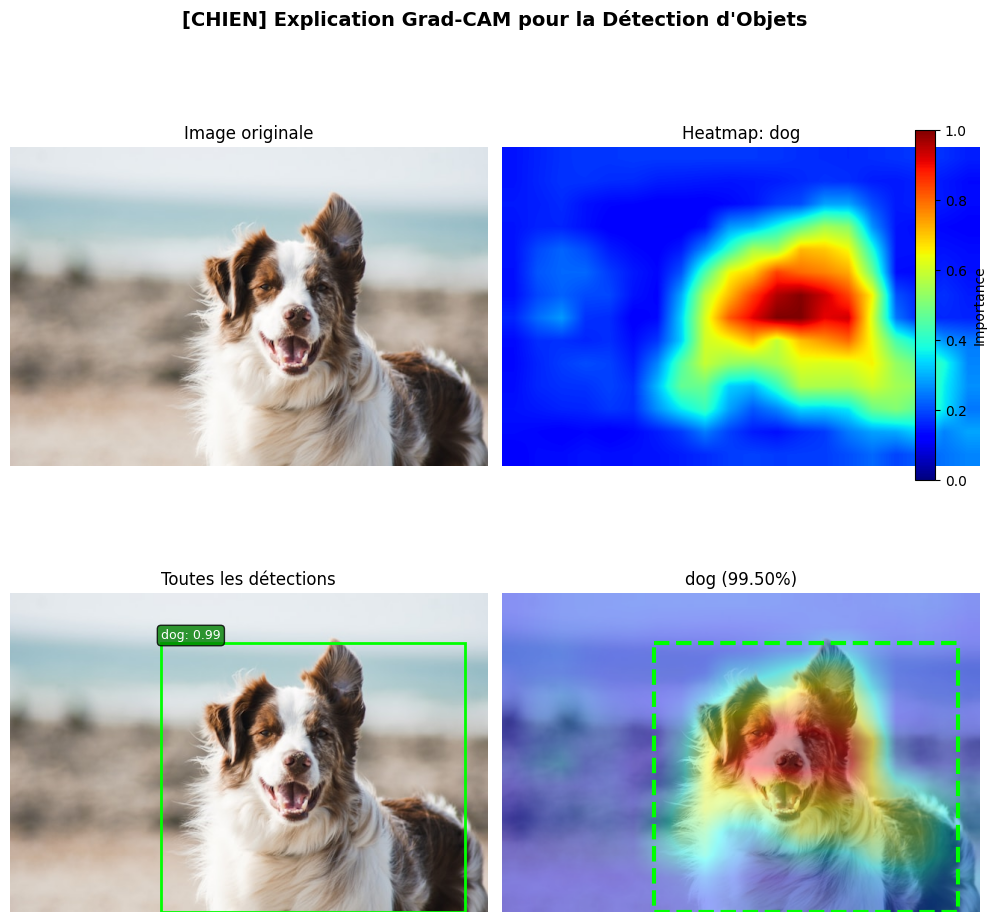


📷 Traitement de l'image: chat
   ✓ 1 heatmap(s) générée(s)
   ✓ 1 heatmap(s) générée(s)


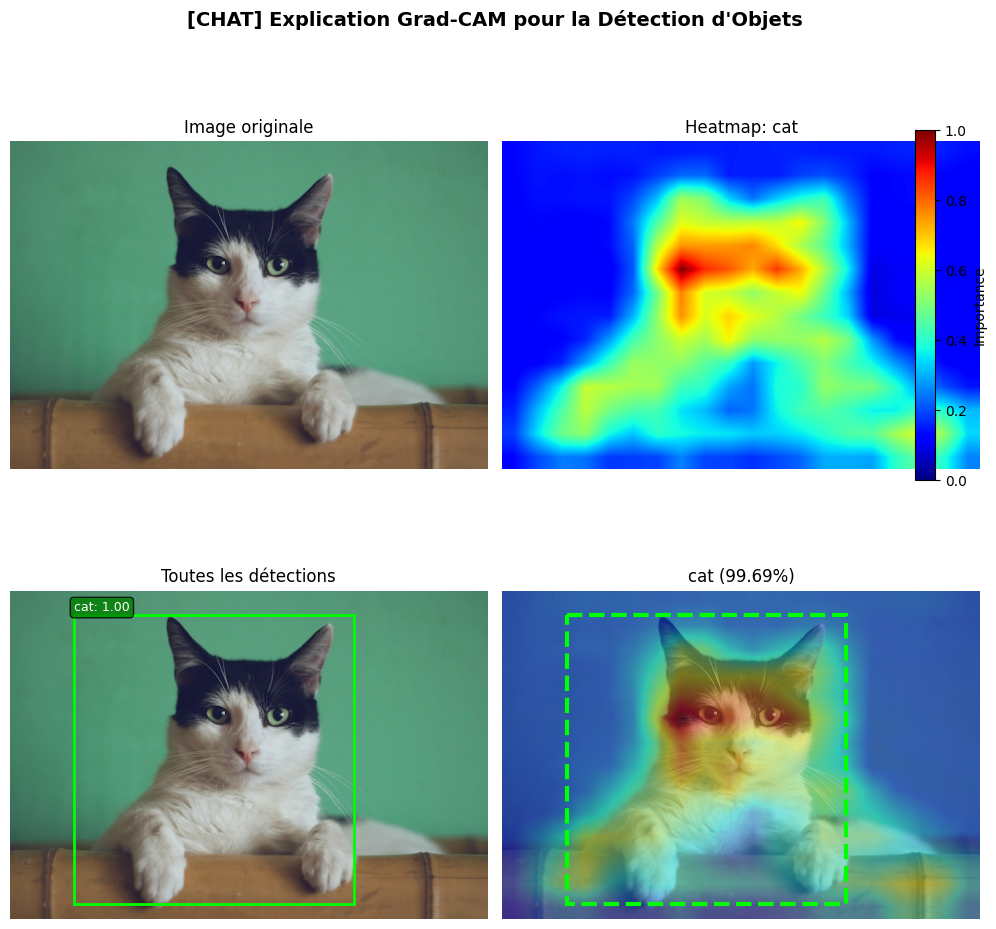


📷 Traitement de l'image: rue
   ✓ 3 heatmap(s) générée(s)
   ✓ 3 heatmap(s) générée(s)


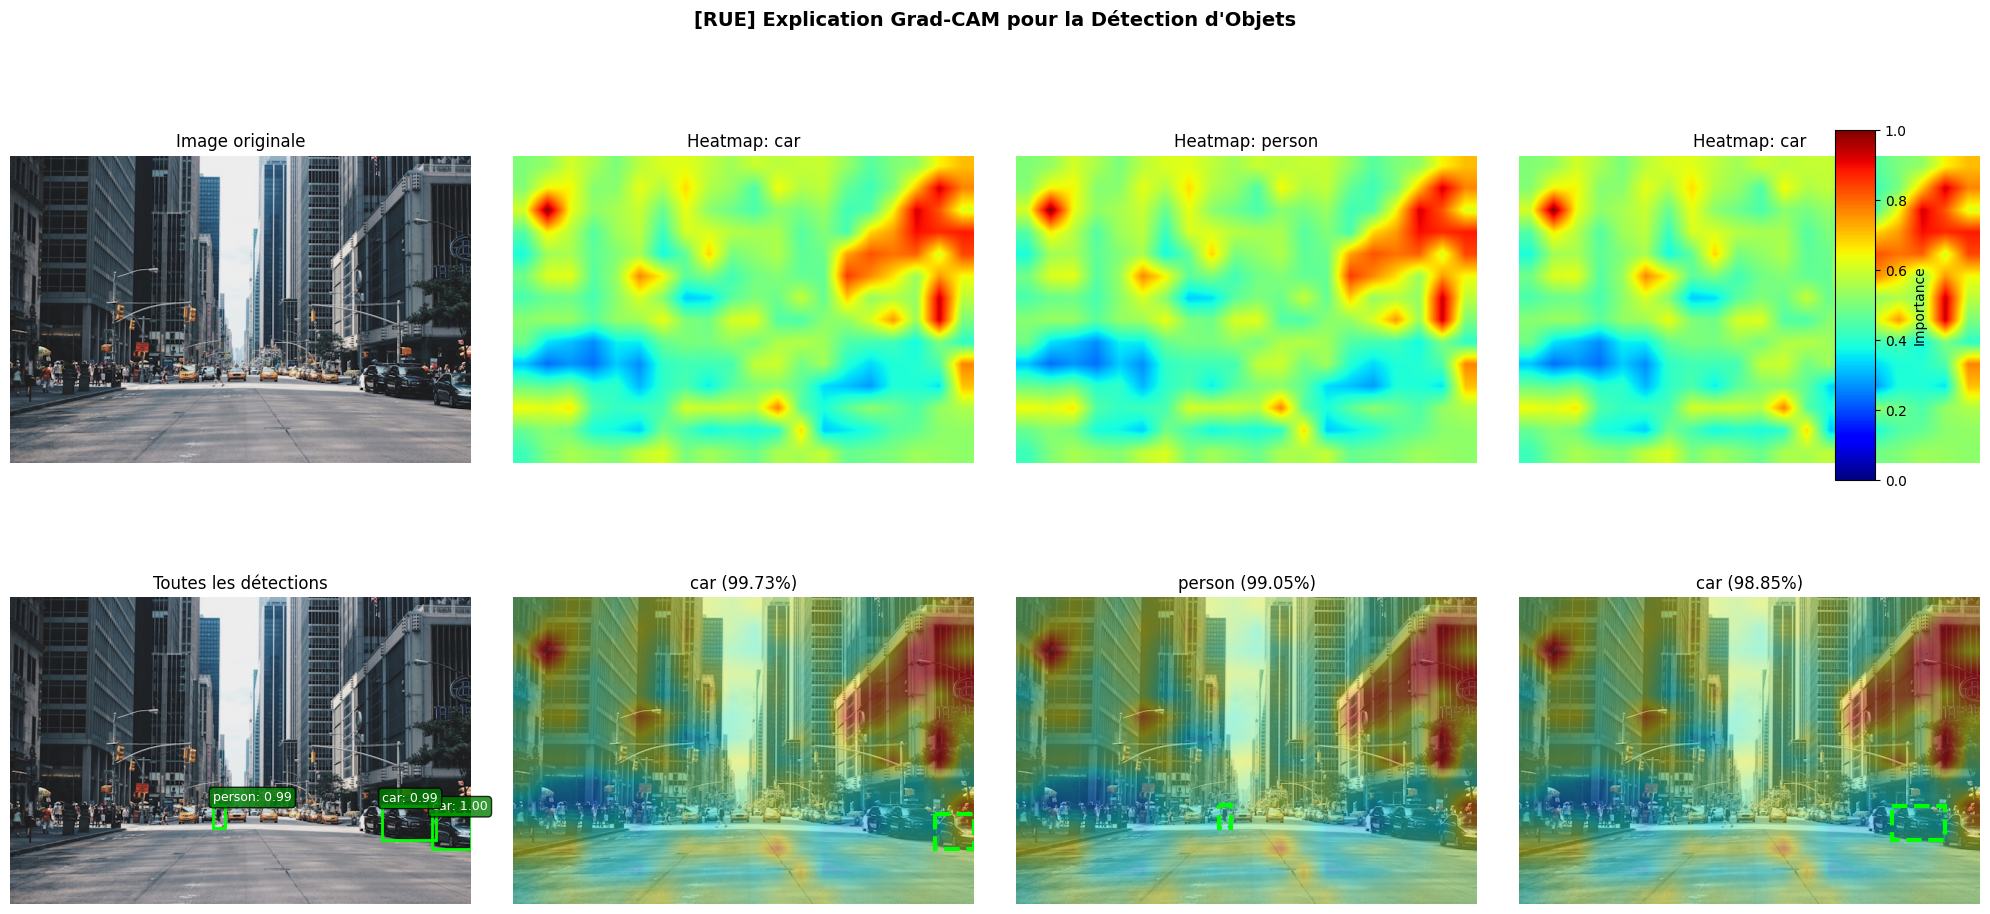

In [17]:
def visualize_gradcam_comparison(img, gradcam_results, class_names, image_name=""):
    """
    Crée une visualisation comparative montrant l'image originale,
    les détections, et les heatmaps Grad-CAM pour chaque boîte.
    """
    n_results = len(gradcam_results)
    if n_results == 0:
        print(f"Aucun résultat à visualiser pour {image_name}")
        return
    
    # Figure avec 2 lignes: original + heatmaps
    fig, axes = plt.subplots(2, n_results + 1, figsize=(5 * (n_results + 1), 10))
    
    # Gérer le cas où il n'y a qu'une seule colonne
    if n_results == 0:
        axes = axes.reshape(2, 1)
    
    img_array = np.array(img)
    
    # Première colonne: image originale avec toutes les détections
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Image originale", fontsize=12)
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(img)
    for res in gradcam_results:
        x1, y1, x2, y2 = res['box']
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        axes[1, 0].add_patch(rect)
        class_name = class_names[res['label']] if res['label'] < len(class_names) else f"cls_{res['label']}"
        axes[1, 0].text(x1, y1 - 5, f"{class_name}: {res['score']:.2f}",
                       color='white', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='green', alpha=0.8))
    axes[1, 0].set_title("Toutes les détections", fontsize=12)
    axes[1, 0].axis('off')
    
    # Colonnes suivantes: heatmaps pour chaque boîte
    im = None
    for i, res in enumerate(gradcam_results):
        cam = res['cam']
        box = res['box']
        label = res['label']
        score = res['score']
        
        class_name = class_names[label] if label < len(class_names) else f"class_{label}"
        
        # Redimensionner la CAM
        cam_resized = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))
        
        # Ligne 1: Heatmap seule
        im = axes[0, i + 1].imshow(cam_resized, cmap='jet', vmin=0, vmax=1)
        axes[0, i + 1].set_title(f"Heatmap: {class_name}", fontsize=12)
        axes[0, i + 1].axis('off')
        
        # Ligne 2: Superposition
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        superimposed = np.uint8(heatmap * 0.4 + img_array * 0.6)
        
        axes[1, i + 1].imshow(superimposed)
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=3, edgecolor='lime', facecolor='none', linestyle='--'
        )
        axes[1, i + 1].add_patch(rect)
        axes[1, i + 1].set_title(f"{class_name} ({score:.2%})", fontsize=12)
        axes[1, i + 1].axis('off')
    
    plt.tight_layout()
    title = f"Explication Grad-CAM pour la Détection d'Objets"
    if image_name:
        title = f"[{image_name.upper()}] " + title
    plt.suptitle(title, y=1.02, fontsize=14, fontweight='bold')
    
    # Ajouter une colorbar si im existe
    if im is not None:
        cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.35])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Importance', fontsize=10)
    
    plt.show()

# ============================================================
# Générer et visualiser les heatmaps pour TOUTES les images
# ============================================================

print("=" * 70)
print("VISUALISATION GRAD-CAM POUR TOUTES LES IMAGES")
print("=" * 70)

# Stocker tous les résultats Grad-CAM
all_gradcam_results = {}

for img_name, det in all_detections.items():
    print(f"\n📷 Traitement de l'image: {img_name}")
    
    if len(det['boxes']) == 0:
        print(f"   ⚠️ Aucune détection pour '{img_name}'")
        continue
    
    # Réinitialiser les états du gradcam
    gradcam.gradients = None
    gradcam.activations = None
    
    # Générer les heatmaps pour cette image
    img_gradcam_results = generate_gradcam_for_detections(
        gradcam, det['image'], det, num_boxes=min(3, len(det['boxes']))
    )
    
    all_gradcam_results[img_name] = img_gradcam_results
    print(f"   ✓ {len(img_gradcam_results)} heatmap(s) générée(s)")
    
    # Visualiser
    visualize_gradcam_comparison(det['image'], img_gradcam_results, COCO_CLASSES, image_name=img_name)

### h) Analyse détaillée avec différentes visualisations

Créons des visualisations supplémentaires pour mieux comprendre les explications.

ANALYSE DÉTAILLÉE POUR CHAQUE IMAGE

📷 IMAGE: CHIEN


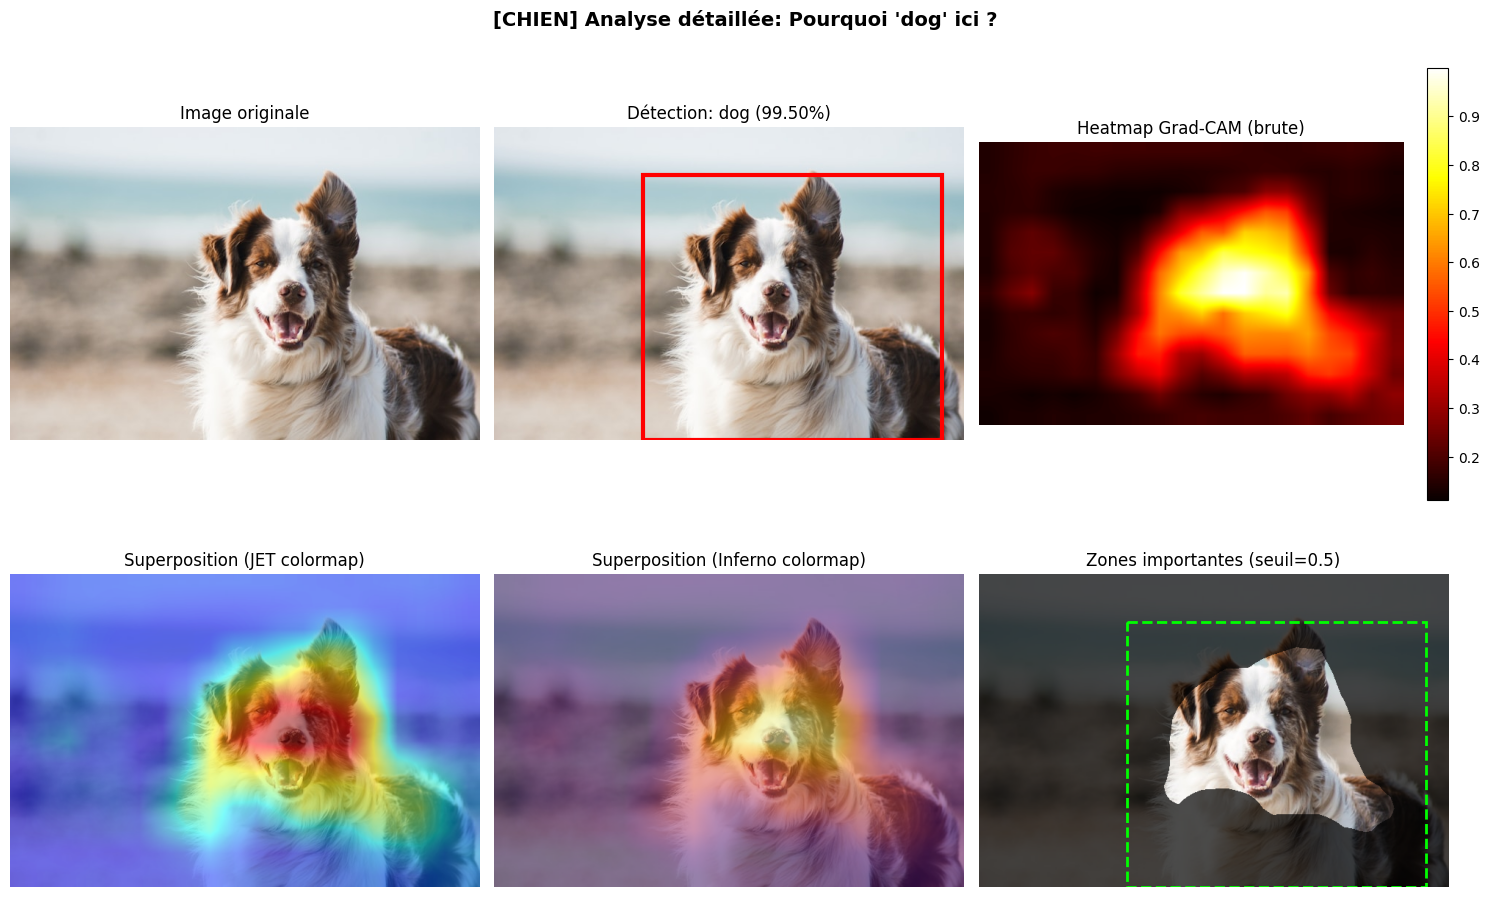


📊 Statistiques de la heatmap pour dog:
   - Valeur max: 0.9999
   - Valeur moyenne: 0.2945
   - % pixels > 0.5: 17.8%
   - % pixels > 0.7: 7.2%

📷 IMAGE: CHAT


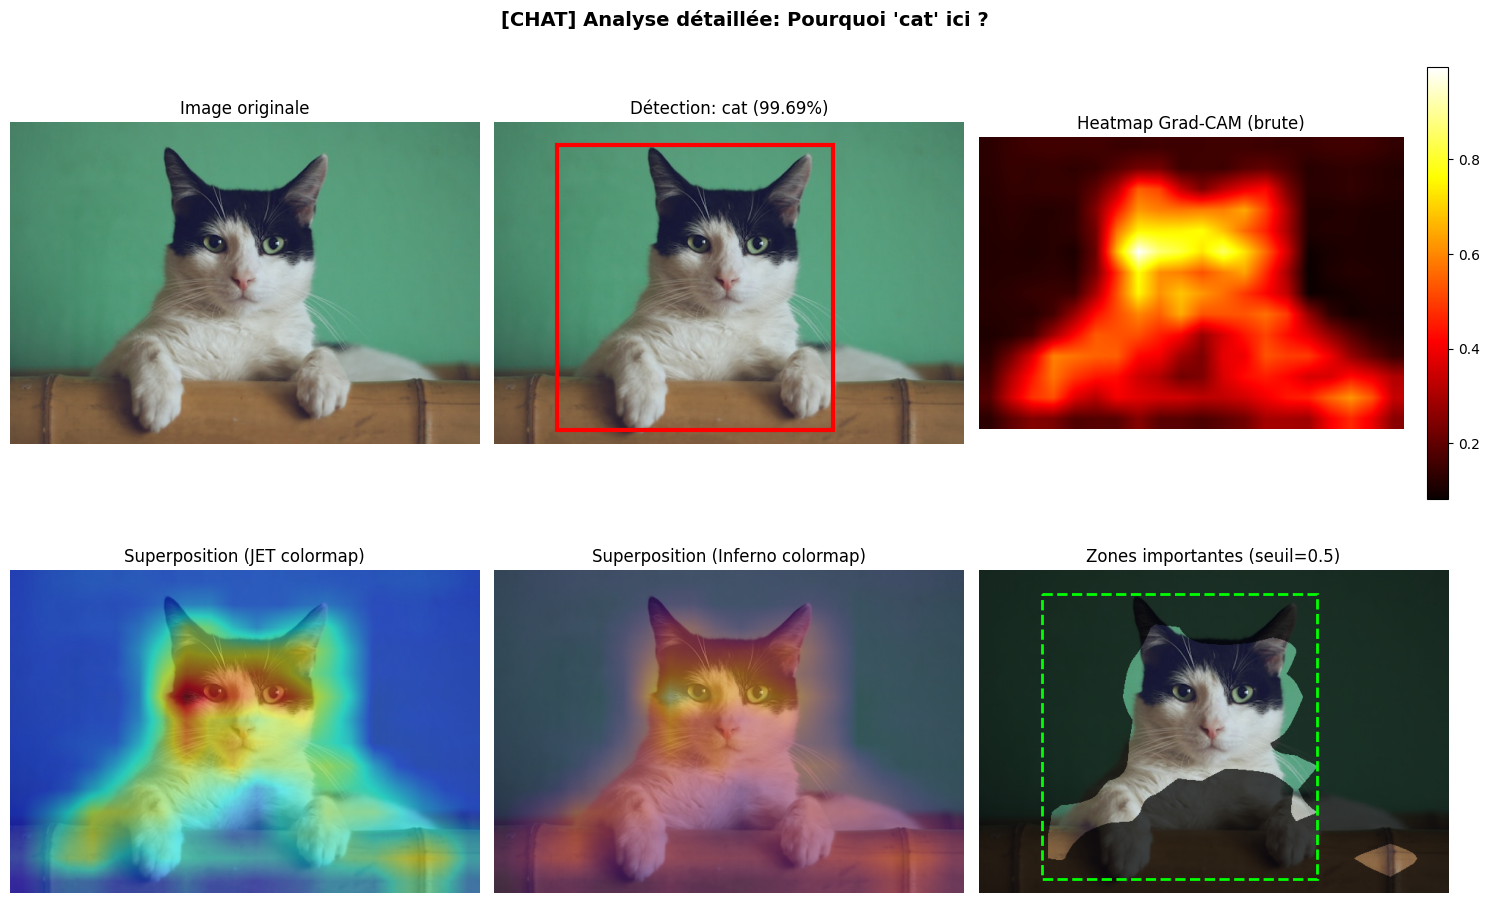


📊 Statistiques de la heatmap pour cat:
   - Valeur max: 0.9951
   - Valeur moyenne: 0.3103
   - % pixels > 0.5: 19.0%
   - % pixels > 0.7: 3.7%

📷 IMAGE: RUE


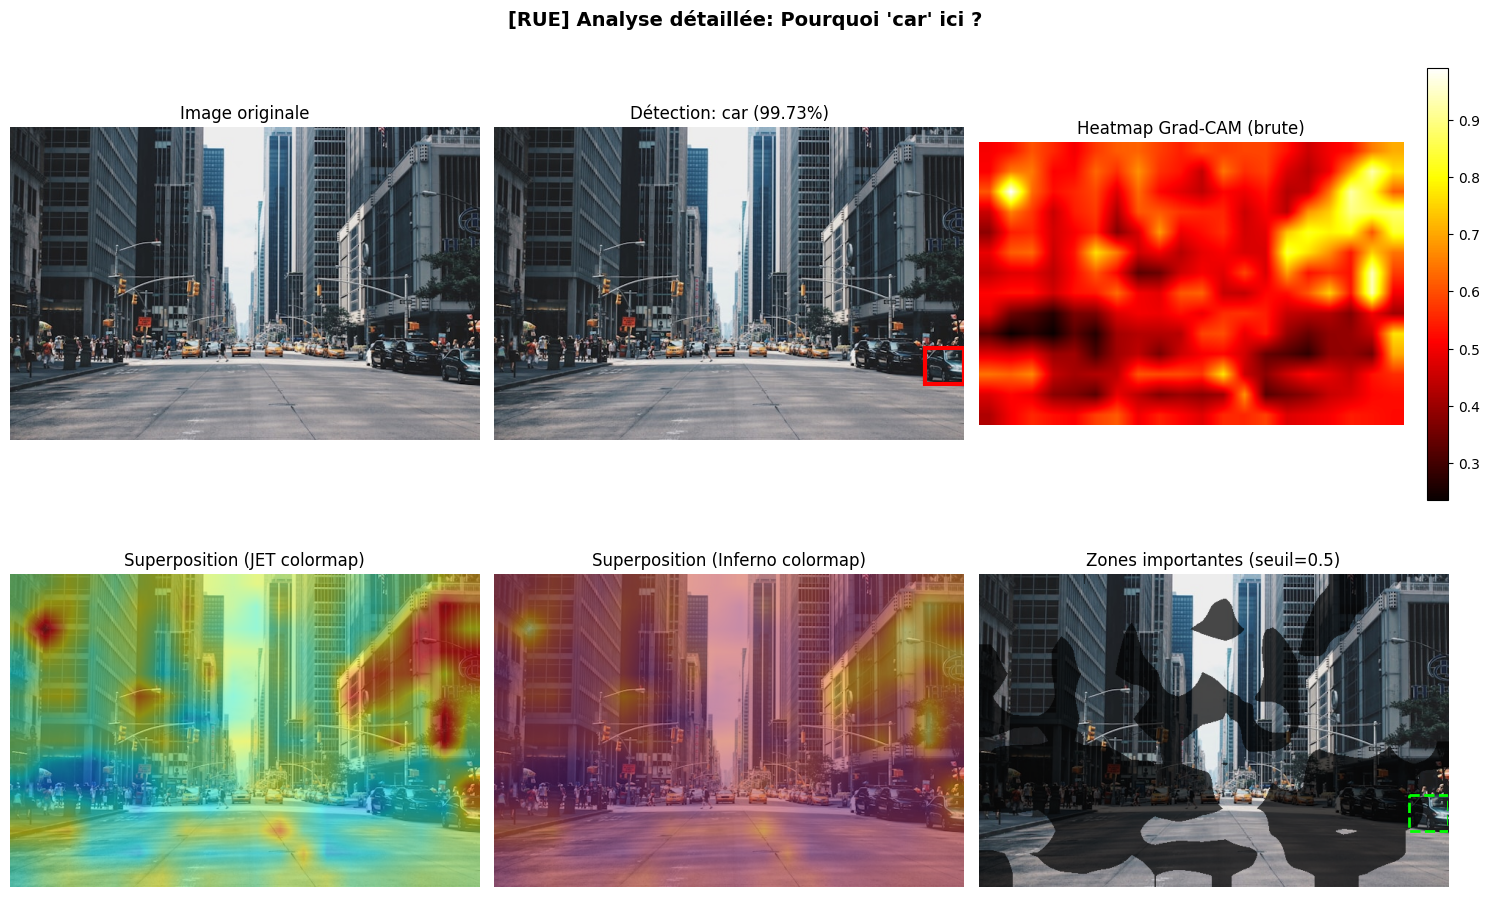


📊 Statistiques de la heatmap pour car:
   - Valeur max: 0.9915
   - Valeur moyenne: 0.5275
   - % pixels > 0.5: 58.9%
   - % pixels > 0.7: 8.4%


In [18]:
def detailed_analysis(img, gradcam_results, class_names, box_idx=0, image_name=""):
    """
    Analyse détaillée d'une boîte spécifique avec plusieurs visualisations.
    """
    if box_idx >= len(gradcam_results):
        print(f"Index {box_idx} invalide. Seulement {len(gradcam_results)} résultats disponibles.")
        return
    
    res = gradcam_results[box_idx]
    cam = res['cam']
    box = res['box']
    label = res['label']
    score = res['score']
    
    class_name = class_names[label] if label < len(class_names) else f"class_{label}"
    img_array = np.array(img)
    
    # Redimensionner CAM
    cam_resized = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Image originale
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Image originale", fontsize=12)
    axes[0, 0].axis('off')
    
    # 2. Boîte de détection
    axes[0, 1].imshow(img)
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=3, edgecolor='red', facecolor='none'
    )
    axes[0, 1].add_patch(rect)
    axes[0, 1].set_title(f"Détection: {class_name} ({score:.2%})", fontsize=12)
    axes[0, 1].axis('off')
    
    # 3. Heatmap brute
    im = axes[0, 2].imshow(cam_resized, cmap='hot')
    axes[0, 2].set_title("Heatmap Grad-CAM (brute)", fontsize=12)
    axes[0, 2].axis('off')
    plt.colorbar(im, ax=axes[0, 2], fraction=0.046)
    
    # 4. Superposition avec colormap JET
    heatmap_jet = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_jet = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    superimposed_jet = np.uint8(heatmap_jet * 0.5 + img_array * 0.5)
    axes[1, 0].imshow(superimposed_jet)
    axes[1, 0].set_title("Superposition (JET colormap)", fontsize=12)
    axes[1, 0].axis('off')
    
    # 5. Superposition avec colormap INFERNO
    heatmap_inferno = plt.cm.inferno(cam_resized)[:, :, :3] * 255
    superimposed_inferno = np.uint8(heatmap_inferno * 0.5 + img_array * 0.5)
    axes[1, 1].imshow(superimposed_inferno)
    axes[1, 1].set_title("Superposition (Inferno colormap)", fontsize=12)
    axes[1, 1].axis('off')
    
    # 6. Zones de forte activation (seuillage)
    threshold = 0.5
    mask = cam_resized > threshold
    masked_img = img_array.copy()
    masked_img[~mask] = masked_img[~mask] * 0.3  # Assombrir les zones non importantes
    axes[1, 2].imshow(masked_img.astype(np.uint8))
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='lime', facecolor='none', linestyle='--'
    )
    axes[1, 2].add_patch(rect)
    axes[1, 2].set_title(f"Zones importantes (seuil={threshold})", fontsize=12)
    axes[1, 2].axis('off')
    
    title = f"Analyse détaillée: Pourquoi '{class_name}' ici ?"
    if image_name:
        title = f"[{image_name.upper()}] " + title
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Statistiques
    print(f"\n📊 Statistiques de la heatmap pour {class_name}:")
    print(f"   - Valeur max: {cam_resized.max():.4f}")
    print(f"   - Valeur moyenne: {cam_resized.mean():.4f}")
    print(f"   - % pixels > 0.5: {100 * np.mean(cam_resized > 0.5):.1f}%")
    print(f"   - % pixels > 0.7: {100 * np.mean(cam_resized > 0.7):.1f}%")

# ============================================================
# Analyse détaillée pour TOUTES les images
# ============================================================

print("=" * 70)
print("ANALYSE DÉTAILLÉE POUR CHAQUE IMAGE")
print("=" * 70)

for img_name, det in all_detections.items():
    print(f"\n{'='*70}")
    print(f"📷 IMAGE: {img_name.upper()}")
    print(f"{'='*70}")
    
    if img_name not in all_gradcam_results or len(all_gradcam_results[img_name]) == 0:
        print(f"   ⚠️ Aucun résultat Grad-CAM disponible pour cette image")
        continue
    
    # Afficher l'analyse détaillée pour la première boîte de chaque image
    detailed_analysis(det['image'], all_gradcam_results[img_name], COCO_CLASSES, box_idx=0, image_name=img_name)

### i) Interprétation des résultats

#### Que montrent les heatmaps ?

Les heatmaps Grad-CAM révèlent les régions de l'image qui ont le plus contribué à la décision de placer une boîte de détection à un endroit précis.

**Observations typiques :**

1. **Zones de forte activation (rouge/jaune)** : Ces régions correspondent généralement aux caractéristiques discriminantes de l'objet détecté :
   - Pour un chien : museau, oreilles, yeux
   - Pour une voiture : phares, roues, carrosserie
   - Pour une personne : visage, silhouette
   
2. **Corrélation avec la boîte** : Idéalement, les zones chaudes devraient être concentrées à l'intérieur de la boîte de détection.

3. **Indicateurs de qualité** :
   - ✅ **Bon signe** : Activation localisée sur l'objet
   - ⚠️ **Attention** : Activation dispersée ou sur le fond
   - ❌ **Problème** : Activation sur des éléments contextuels (biais)

In [19]:
# Fonction pour calculer le score d'alignement boîte/heatmap
def compute_alignment_score(cam, box, img_shape):
    """
    Calcule un score mesurant l'alignement entre la heatmap et la boîte.
    
    Score = (activation moyenne dans la boîte) / (activation moyenne hors boîte)
    Un score > 1 signifie que l'activation est bien focalisée sur la boîte.
    """
    cam_resized = cv2.resize(cam, (img_shape[1], img_shape[0]))
    
    x1, y1, x2, y2 = [int(c) for c in box]
    
    # Créer un masque pour la boîte
    mask = np.zeros_like(cam_resized, dtype=bool)
    mask[y1:y2, x1:x2] = True
    
    # Calculer les moyennes
    mean_inside = cam_resized[mask].mean() if mask.sum() > 0 else 0
    mean_outside = cam_resized[~mask].mean() if (~mask).sum() > 0 else 1
    
    # Éviter division par zéro
    if mean_outside == 0:
        mean_outside = 1e-6
    
    alignment_score = mean_inside / mean_outside
    
    return alignment_score, mean_inside, mean_outside

# Analyser l'alignement pour toutes les détections
if 'gradcam_results' in dir() and len(gradcam_results) > 0:
    print("📈 Analyse d'alignement Heatmap ↔ Boîte:\n")
    print("-" * 60)
    
    img_array = np.array(test_img)
    
    for i, res in enumerate(gradcam_results):
        class_name = COCO_CLASSES[res['label']] if res['label'] < len(COCO_CLASSES) else f"cls_{res['label']}"
        alignment, mean_in, mean_out = compute_alignment_score(
            res['cam'], res['box'], img_array.shape
        )
        
        # Emoji basé sur le score
        if alignment > 2:
            emoji = "🟢"  # Excellent
            verdict = "Excellent - activation bien focalisée"
        elif alignment > 1:
            emoji = "🟡"  # Bon
            verdict = "Bon - activation principalement dans la boîte"
        else:
            emoji = "🔴"  # Problématique
            verdict = "Attention - activation dispersée ou hors boîte"
        
        print(f"Boîte {i+1}: {class_name}")
        print(f"   Score d'alignement: {alignment:.2f} {emoji}")
        print(f"   Activation dans la boîte: {mean_in:.4f}")
        print(f"   Activation hors boîte: {mean_out:.4f}")
        print(f"   Verdict: {verdict}")
        print("-" * 60)

📈 Analyse d'alignement Heatmap ↔ Boîte:

------------------------------------------------------------
Boîte 1: dog
   Score d'alignement: 2.42 🟢
   Activation dans la boîte: 0.4036
   Activation hors boîte: 0.1669
   Verdict: Excellent - activation bien focalisée
------------------------------------------------------------


##  Discussion critique : Forces & Limites

###  Forces de Grad-CAM pour la détection

| Aspect | Évaluation |
|--------|------------|
| **Rapidité** | ⭐⭐⭐⭐⭐ Un seul forward + backward pass |
| **Simplicité** | ⭐⭐⭐⭐ Facile à implémenter et comprendre |
| **Interprétabilité** | ⭐⭐⭐⭐ Heatmaps visuellement intuitives |
| **Flexibilité** | ⭐⭐⭐⭐ Applicable à tout CNN avec feature maps |

**Avantages par rapport à d'autres méthodes :**

- **vs LIME** : Pas besoin de perturbations multiples (plus rapide)
- **vs SHAP** : Pas de calcul combinatoire coûteux
- **vs Saliency Maps** : Plus lisses et moins bruitées grâce au pooling des gradients

---

###  Limites et pièges

1. **Résolution limitée**
   - Les feature maps de la dernière couche sont de basse résolution
   - La heatmap est approximative et perd les détails fins
   
2. **Explication globale de la couche**
   - La heatmap reflète l'importance pour TOUTES les détections
   - Difficile d'isoler parfaitement une seule boîte
   
3. **Sensibilité à l'architecture**
   - Le choix de la couche cible influence fortement les résultats
   - Pas toujours évident de choisir la "bonne" couche
   
4. **Pas de quantification de l'incertitude**
   - La heatmap ne dit pas "à quel point" le modèle est sûr de son explication
   
5. **Risque d'interprétation erronée**
   - Une forte activation peut correspondre à des corrélations spurieuses
   - Le modèle peut "tricher" (ex: détecter un chien via la laisse)

---

###  Contextes d'utilisation

| Contexte | Recommandation |
|----------|----------------|
| **Debugging de modèle** | ✅ Très utile pour identifier des comportements anormaux |
| **Communication aux non-experts** | ✅ Les heatmaps sont intuitives |
| **Décisions critiques (médical, juridique)** | ⚠️ À utiliser en complément d'autres méthodes |
| **Certification/Audit** | ❌ Insuffisant seul, manque de garanties formelles |

In [20]:
# Démonstration de la sensibilité au choix de la couche cible
def compare_layers(model, img, layers_dict, box_index=0):
    """
    Compare les heatmaps générées par différentes couches du réseau.
    """
    img_tensor = preprocess_image(img).to(device)
    results = {}
    
    for layer_name, layer in layers_dict.items():
        # Créer un nouveau GradCAM pour chaque couche
        gradcam_layer = GradCAMForDetection(model, layer)
        cam, _ = gradcam_layer.generate_cam(img_tensor, box_index=box_index)
        
        if cam is not None:
            results[layer_name] = cam
    
    return results

# Définir plusieurs couches à comparer
layers_to_compare = {
    "Layer 2": model.backbone.body.layer2[-1],
    "Layer 3": model.backbone.body.layer3[-1],
    "Layer 4": model.backbone.body.layer4[-1],
}

print("Comparaison de différentes couches cibles:")
print("=" * 50)

# Cette comparaison montre comment le choix de la couche affecte l'explication
for name in layers_to_compare:
    print(f"• {name}: résolution différente, niveau d'abstraction différent")

Comparaison de différentes couches cibles:
• Layer 2: résolution différente, niveau d'abstraction différent
• Layer 3: résolution différente, niveau d'abstraction différent
• Layer 4: résolution différente, niveau d'abstraction différent


##  Conclusion & Points à retenir

###  Ce que ce mini-projet a démontré

Ce notebook illustre que les techniques d'**Explainable AI (XAI)** ne sont pas limitées aux tâches de classification simple. En adaptant Grad-CAM à la détection d'objets, nous avons montré qu'il est possible d'expliquer des prédictions plus complexes impliquant à la fois :
- Une **localisation spatiale** (où est l'objet ?)
- Une **classification** (qu'est-ce que c'est ?)
- Un **score de confiance** (à quel point le modèle est-il sûr ?)

---

###  Points clés à retenir

1. **Grad-CAM s'adapte bien à la détection** en ciblant le score d'une boîte spécifique plutôt qu'une classe globale. Les gradients sont calculés par rapport aux feature maps du backbone (ResNet, VGG, etc.).

2. **Les heatmaps révèlent les régions discriminantes** utilisées par le modèle pour justifier une détection. C'est un outil précieux pour le debugging et la validation de modèles.

3. **La résolution est une limite importante** : les feature maps de haut niveau ont une résolution spatiale faible, ce qui donne des heatmaps approximatives.

4. **Le choix de la couche cible impacte les résultats** : couches profondes = sémantique de haut niveau mais basse résolution ; couches moins profondes = plus de détails mais moins de sémantique.

5. **À utiliser en complément d'autres analyses** : Grad-CAM ne suffit pas pour des décisions critiques. Combiner avec des méthodes de perturbation (LIME, D-RISE) ou d'autres approches (attention maps, contrefactuels).

---

### 🚀 Extensions possibles

- **D-RISE** : Méthode de perturbation spécifiquement conçue pour la détection d'objets
- **Grad-CAM++** : Version améliorée avec meilleure localisation
- **Score-CAM** : Alternative sans gradients, plus stable
- **Attention Maps** : Pour les architectures avec mécanismes d'attention (DETR, ViT)
- **Contrefactuels visuels** : "Que faudrait-il changer dans l'image pour que la détection disparaisse ?"

##  Références & Liens

###  Articles scientifiques

1. **Grad-CAM (original)** :  
   Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017).  
   *"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"*  
   ICCV 2017. [arXiv:1610.02391](https://arxiv.org/abs/1610.02391)

2. **D-RISE pour la détection** :  
   Petsiuk, V., Jain, R., Manjunatha, V., Morariu, V. I., Meber, A., & Saenko, K. (2021).  
   *"Black-box Explanation of Object Detectors via Saliency Maps"*  
   CVPR 2021. [arXiv:2006.03204](https://arxiv.org/abs/2006.03204)

3. **Grad-CAM++** :  
   Chattopadhay, A., Sarkar, A., Howlader, P., & Balasubramanian, V. N. (2018).  
   *"Grad-CAM++: Generalized Gradient-based Visual Explanations for Deep Convolutional Networks"*  
   WACV 2018.

---

### 🔧 Documentation technique

- **PyTorch Grad-CAM** : [https://github.com/jacobgil/pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam)
- **Torchvision Detection** : [https://pytorch.org/vision/stable/models.html#object-detection](https://pytorch.org/vision/stable/models.html#object-detection)
- **Ultralytics YOLO** : [https://docs.ultralytics.com/](https://docs.ultralytics.com/)

---

###  Tutoriels et ressources complémentaires

- Explainability in Object Detection: [https://pub.towardsai.net/](https://pub.towardsai.net/)
- Captum (PyTorch Interpretability) : [https://captum.ai/](https://captum.ai/)
- XAI Methods Survey : [https://arxiv.org/abs/2104.12644](https://arxiv.org/abs/2104.12644)

